In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import math
from skimage.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import time
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

# set the max columns to none
pd.set_option('display.max_columns', None)

# 1. Load data

In [116]:
df = pd.read_csv('df.csv')
df

,start MTU (UTC),Day-ahead Price [EUR/MWh] BZN|NO1,Day-ahead Price [EUR/MWh] BZN|NO3,Day-ahead Price [EUR/MWh] BZN|NO5,Day-ahead Price [EUR/MWh] BZN|SE3,Actual Total Load [MW] - BZN|NO5,Hydro Run-of-river and poundage - BZN|NO1,Hydro Water Reservoir - BZN|NO1,Wind Onshore - BZN|NO1,Hydro Pumped Storage Aggregated- BZN|NO2,Hydro Run-of-river and poundage - BZN|NO2,Hydro Water Reservoir - BZN|NO2,Waste - BZN|NO2,Wind Onshore - BZN|NO2,Hydro Pumped Storage Aggregated- BZN|NO3,Hydro Run-of-river and poundage - BZN|NO3,Hydro Water Reservoir - BZN|NO3,Other renewable - BZN|NO3,Wind Onshore - BZN|NO3,Fossil Gas - BZN|NO5,Hydro Pumped Storage Aggregated- BZN|NO5,Hydro Run-of-river and poundage - BZN|NO5,Waste - BZN|NO5,Hydro Water Reservoir - BZN|SE3,Nuclear - BZN|SE3,Solar - BZN|SE3,Wind Onshore - BZN|SE3,CBF BZN|NO2 > BZN|NO1 [MW],CBF BZN|NO1 > BZN|NO2 [MW],CBF BZN|NO3 > BZN|NO1 [MW],CBF BZN|NO1 > BZN|NO3 [MW],CBF BZN|NO5 > BZN|NO1 [MW],CBF BZN|NO1 > BZN|NO5 [MW],CBF BZN|SE3 > BZN|NO1 [MW],CBF BZN|NO1 > BZN|SE3 [MW],Stored Energy Value Water Reservoirs and Hydro Storage Plants [MWh] - BZN|NO3,Stored Energy Value Water Reservoirs and Hydro Storage Plants [MWh] - BZN|SE3
0,2022-01-01 00:00:00,129.30,41.33,129.30,41.33,1991.000000,878.0,321.0,172.0,1.0,629.0,2153.333333,5.0,244.0,40.0,389.0,2166.0,12.0,219.0,82.0,66.0,227.0,19.0,818.0,5842.0,0.0,999.0,1242.0,0.0,371.0,0.0,594.0,0.0,1065.0,0.0,5688093.0,1656000.0
1,2022-01-01 01:00:00,132.08,42.18,132.08,42.18,1992.666667,897.0,330.0,151.0,1.0,627.0,2012.000000,4.0,115.0,42.0,390.0,2187.0,12.0,170.0,82.0,66.0,216.0,20.0,818.0,5839.0,0.0,958.0,1222.0,0.0,383.0,0.0,676.0,0.0,927.0,0.0,5688093.0,1656000.0
2,2022-01-01 02:00:00,111.44,44.37,111.44,44.37,1994.333333,885.0,275.0,160.0,1.0,624.0,1999.555556,4.0,55.0,45.0,405.0,2183.0,12.0,126.0,82.0,65.0,215.0,20.0,838.0,5839.0,0.0,888.0,1679.0,0.0,362.0,0.0,436.0,0.0,748.0,0.0,5688093.0,1656000.0
3,2022-01-01 03:00:00,112.35,37.67,112.35,37.67,1996.000000,890.0,269.0,148.0,1.0,624.0,1987.111111,4.0,61.0,34.0,393.0,2076.0,12.0,81.0,82.0,65.0,209.0,20.0,842.0,5840.0,0.0,788.0,1668.0,0.0,324.0,0.0,345.0,0.0,918.0,0.0,5688093.0,1656000.0
4,2022-01-01 04:00:00,113.90,39.70,113.90,39.70,1985.500000,892.0,300.0,147.0,1.0,605.0,1974.666667,4.0,88.0,38.0,398.0,2098.0,11.0,45.0,82.0,65.0,210.0,19.0,841.0,5839.0,0.0,734.0,1697.0,0.0,339.0,0.0,412.0,0.0,826.0,0.0,5688093.0,1656000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2022-12-31 19:00:00,123.61,23.82,123.61,11.57,2128.000000,992.0,621.0,74.0,1.0,823.0,2399.000000,13.0,443.0,34.0,187.0,987.0,23.0,1576.0,7.0,24.0,148.0,14.0,627.0,5796.0,0.0,1499.0,621.0,0.0,146.0,0.0,43.0,0.0,2083.0,0.0,5038234.0,1579000.0
8756,2022-12-31 20:00:00,121.09,23.93,121.09,14.89,2089.000000,980.0,610.0,70.5,1.0,828.0,2265.000000,13.0,443.0,35.0,187.0,997.0,23.0,1548.0,7.0,25.0,135.0,14.0,573.0,5797.0,0.0,1282.0,595.0,0.0,124.0,0.0,24.0,0.0,2097.0,0.0,5038234.0,1579000.0
8757,2022-12-31 21:00:00,120.00,23.75,120.00,9.94,2037.000000,980.0,588.0,67.0,1.0,814.0,2265.000000,13.0,443.0,35.0,182.0,868.0,23.0,1525.0,7.0,25.0,127.0,14.0,544.0,5797.0,0.0,1168.0,608.0,0.0,91.0,0.0,41.0,0.0,2007.0,0.0,5038234.0,1579000.0
8758,2022-12-31 22:00:00,119.98,23.56,119.98,4.84,1991.000000,989.0,585.0,69.0,0.0,814.0,2098.000000,13.0,443.0,35.0,183.0,814.0,23.0,1498.0,7.0,25.0,137.0,14.0,539.0,5796.0,0.0,1033.0,504.0,0.0,90.0,0.0,0.0,29.0,2119.0,0.0,5038234.0,1579000.0


In [117]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 37 columns):
 #   Column                                                                         Non-Null Count  Dtype  
---  ------                                                                         --------------  -----  
 0   start MTU (UTC)                                                                8760 non-null   object 
 1   Day-ahead Price [EUR/MWh] BZN|NO1                                              8760 non-null   float64
 2   Day-ahead Price [EUR/MWh] BZN|NO3                                              8760 non-null   float64
 3   Day-ahead Price [EUR/MWh] BZN|NO5                                              8760 non-null   float64
 4   Day-ahead Price [EUR/MWh] BZN|SE3                                              8760 non-null   float64
 5   Actual Total Load [MW] - BZN|NO5                                               8760 non-null   float64
 6   Hydro Run-of-river and p

# 2. Preprocessing

#### 2.1 Indexing

In [118]:
df = df.set_index('start MTU (UTC)')
df.index = pd.to_datetime(df.index)
df = df.sort_index()
df.index

DatetimeIndex(['2022-01-01 00:00:00', '2022-01-01 01:00:00',
               '2022-01-01 02:00:00', '2022-01-01 03:00:00',
               '2022-01-01 04:00:00', '2022-01-01 05:00:00',
               '2022-01-01 06:00:00', '2022-01-01 07:00:00',
               '2022-01-01 08:00:00', '2022-01-01 09:00:00',
               ...
               '2022-12-31 14:00:00', '2022-12-31 15:00:00',
               '2022-12-31 16:00:00', '2022-12-31 17:00:00',
               '2022-12-31 18:00:00', '2022-12-31 19:00:00',
               '2022-12-31 20:00:00', '2022-12-31 21:00:00',
               '2022-12-31 22:00:00', '2022-12-31 23:00:00'],
              dtype='datetime64[ns]', name='start MTU (UTC)', length=8760, freq=None)

#### 2.2 Removing symbols from feature names

In [119]:
import re

regex = re.compile(r"\[|\]|<", re.IGNORECASE)
df.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<', '>'))) else col for col in df.columns.values]

#### 2.3 Plotting 'Day-ahead Price BZN|NO1'

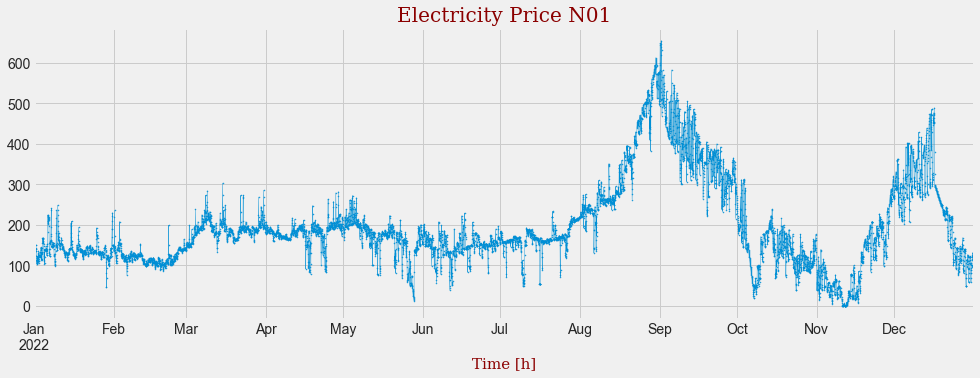

In [120]:
target_column = df['Day-ahead Price _EUR/MWh_ BZN|NO1']
target_column_df =  pd.DataFrame(target_column)
target_column.plot( figsize=(15, 5), color=color_pal[0], lw=0.4, marker="." , markersize=1)

font1 = {'family':'serif','color':'darkred','size':20}
font2 = {'family':'serif','color':'darkred','size':15}
plt.title("Electricity Price N01", fontdict = font1)
plt.xlabel("Time [h]", fontdict = font2)
plt.show()

<AxesSubplot:ylabel='Frequency'>

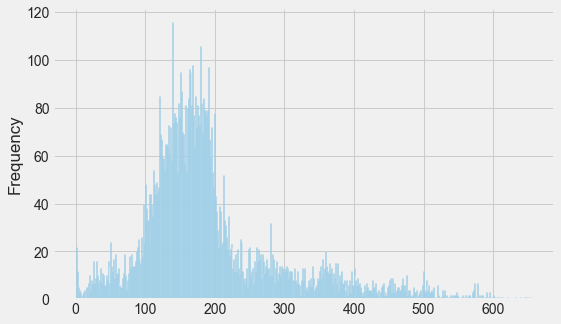

In [121]:
df['Day-ahead Price _EUR/MWh_ BZN|NO1'].plot(kind='hist',figsize=(8, 5), bins=500)

#### 2.4 Feature engineering

#### 2.4.1 Create hour feature

In [122]:
def create_features (df):
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    return df
create_features(df)

,Day-ahead Price _EUR/MWh_ BZN|NO1,Day-ahead Price _EUR/MWh_ BZN|NO3,Day-ahead Price _EUR/MWh_ BZN|NO5,Day-ahead Price _EUR/MWh_ BZN|SE3,Actual Total Load _MW_ - BZN|NO5,Hydro Run-of-river and poundage - BZN|NO1,Hydro Water Reservoir - BZN|NO1,Wind Onshore - BZN|NO1,Hydro Pumped Storage Aggregated- BZN|NO2,Hydro Run-of-river and poundage - BZN|NO2,Hydro Water Reservoir - BZN|NO2,Waste - BZN|NO2,Wind Onshore - BZN|NO2,Hydro Pumped Storage Aggregated- BZN|NO3,Hydro Run-of-river and poundage - BZN|NO3,Hydro Water Reservoir - BZN|NO3,Other renewable - BZN|NO3,Wind Onshore - BZN|NO3,Fossil Gas - BZN|NO5,Hydro Pumped Storage Aggregated- BZN|NO5,Hydro Run-of-river and poundage - BZN|NO5,Waste - BZN|NO5,Hydro Water Reservoir - BZN|SE3,Nuclear - BZN|SE3,Solar - BZN|SE3,Wind Onshore - BZN|SE3,CBF BZN|NO2 > BZN|NO1 _MW_,CBF BZN|NO1 > BZN|NO2 _MW_,CBF BZN|NO3 > BZN|NO1 _MW_,CBF BZN|NO1 > BZN|NO3 _MW_,CBF BZN|NO5 > BZN|NO1 _MW_,CBF BZN|NO1 > BZN|NO5 _MW_,CBF BZN|SE3 > BZN|NO1 _MW_,CBF BZN|NO1 > BZN|SE3 _MW_,Stored Energy Value Water Reservoirs and Hydro Storage Plants _MWh_ - BZN|NO3,Stored Energy Value Water Reservoirs and Hydro Storage Plants _MWh_ - BZN|SE3,hour,dayofweek
start MTU (UTC),,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:00:00,129.30,41.33,129.30,41.33,1991.000000,878.0,321.0,172.0,1.0,629.0,2153.333333,5.0,244.0,40.0,389.0,2166.0,12.0,219.0,82.0,66.0,227.0,19.0,818.0,5842.0,0.0,999.0,1242.0,0.0,371.0,0.0,594.0,0.0,1065.0,0.0,5688093.0,1656000.0,0,5
2022-01-01 01:00:00,132.08,42.18,132.08,42.18,1992.666667,897.0,330.0,151.0,1.0,627.0,2012.000000,4.0,115.0,42.0,390.0,2187.0,12.0,170.0,82.0,66.0,216.0,20.0,818.0,5839.0,0.0,958.0,1222.0,0.0,383.0,0.0,676.0,0.0,927.0,0.0,5688093.0,1656000.0,1,5
2022-01-01 02:00:00,111.44,44.37,111.44,44.37,1994.333333,885.0,275.0,160.0,1.0,624.0,1999.555556,4.0,55.0,45.0,405.0,2183.0,12.0,126.0,82.0,65.0,215.0,20.0,838.0,5839.0,0.0,888.0,1679.0,0.0,362.0,0.0,436.0,0.0,748.0,0.0,5688093.0,1656000.0,2,5
2022-01-01 03:00:00,112.35,37.67,112.35,37.67,1996.000000,890.0,269.0,148.0,1.0,624.0,1987.111111,4.0,61.0,34.0,393.0,2076.0,12.0,81.0,82.0,65.0,209.0,20.0,842.0,5840.0,0.0,788.0,1668.0,0.0,324.0,0.0,345.0,0.0,918.0,0.0,5688093.0,1656000.0,3,5
2022-01-01 04:00:00,113.90,39.70,113.90,39.70,1985.500000,892.0,300.0,147.0,1.0,605.0,1974.666667,4.0,88.0,38.0,398.0,2098.0,11.0,45.0,82.0,65.0,210.0,19.0,841.0,5839.0,0.0,734.0,1697.0,0.0,339.0,0.0,412.0,0.0,826.0,0.0,5688093.0,1656000.0,4,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,123.61,23.82,123.61,11.57,2128.000000,992.0,621.0,74.0,1.0,823.0,2399.000000,13.0,443.0,34.0,187.0,987.0,23.0,1576.0,7.0,24.0,148.0,14.0,627.0,5796.0,0.0,1499.0,621.0,0.0,146.0,0.0,43.0,0.0,2083.0,0.0,5038234.0,1579000.0,19,5
2022-12-31 20:00:00,121.09,23.93,121.09,14.89,2089.000000,980.0,610.0,70.5,1.0,828.0,2265.000000,13.0,443.0,35.0,187.0,997.0,23.0,1548.0,7.0,25.0,135.0,14.0,573.0,5797.0,0.0,1282.0,595.0,0.0,124.0,0.0,24.0,0.0,2097.0,0.0,5038234.0,1579000.0,20,5
2022-12-31 21:00:00,120.00,23.75,120.00,9.94,2037.000000,980.0,588.0,67.0,1.0,814.0,2265.000000,13.0,443.0,35.0,182.0,868.0,23.0,1525.0,7.0,25.0,127.0,14.0,544.0,5797.0,0.0,1168.0,608.0,0.0,91.0,0.0,41.0,0.0,2007.0,0.0,5038234.0,1579000.0,21,5


#### 2.4.2  Visualize target and hour feature's relationship

<function matplotlib.pyplot.show(close=None, block=None)>

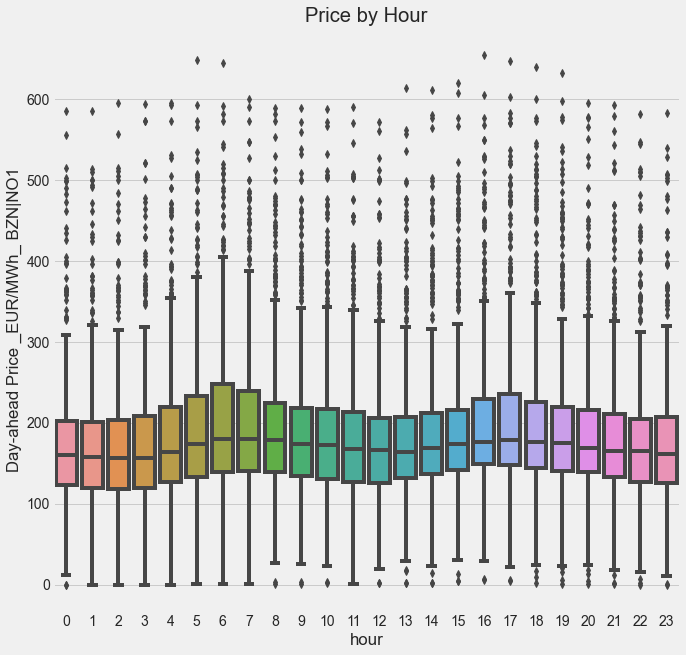

In [123]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.boxplot(data=df, x='hour', y='Day-ahead Price _EUR/MWh_ BZN|NO1')
ax.set_title('Price by Hour')
plt.show


#### 2.4.3 Create lag features
lag feature can not be longer than our forecasting horizon(24h). Creating 24 new features for each existing feature(36), these 24 new features contain 24 previous values. At each specific time sample we have access to 24 previous values. In total, we create 24 * 36 = 864 new features. We call of these features lagged features. The dataset has now 864 + 36 = 900 features. For prediction target feature is not used , therefore our model will have 899 features as input for making prediction.

In [124]:
def create_lagged_features(dataframe, lag_hours):
    lagged_features = []
    for col in dataframe.columns:
        for i in range(1, lag_hours+1):
            col_name = '{}_lag_{}'.format(col, i)
            lagged_features.append(dataframe[col].shift(i).rename(col_name))
    lagged_features_df = pd.concat(lagged_features, axis=1)
    new_dataframe = pd.concat([dataframe, lagged_features_df], axis=1).dropna()
    return new_dataframe

#### Find feature names for all generated lagged FEATURES

In [125]:
def get_lagged_feature_names(features, lag_hours):
    lagged_features = []
    for col in features:
        for i in range(1, lag_hours+1):
            col_name = '{}_lag_{}'.format(col, i)
            lagged_features.append(col_name)
    return lagged_features

def get_lagged_target_name(target, lag_hours):
    lagged_target = []
    for i in range(1, lag_hours+1):
        col_name = '{}_lag_{}'.format(target, i)
        lagged_target.append(col_name)
    return lagged_target

In [126]:
TARGET = 'Day-ahead Price _EUR/MWh_ BZN|NO1'

FEATURES = [
    'Day-ahead Price _EUR/MWh_ BZN|NO3',
    'Day-ahead Price _EUR/MWh_ BZN|NO5',
    'Day-ahead Price _EUR/MWh_ BZN|SE3', 'Actual Total Load _MW_ - BZN|NO5',
    'Hydro Run-of-river and poundage - BZN|NO1',
    'Hydro Water Reservoir - BZN|NO1', 'Wind Onshore - BZN|NO1',
    'Hydro Pumped Storage Aggregated- BZN|NO2',
    'Hydro Run-of-river and poundage - BZN|NO2',
    'Hydro Water Reservoir - BZN|NO2',
    'Waste - BZN|NO2',
    'Wind Onshore - BZN|NO2', 'Hydro Pumped Storage Aggregated- BZN|NO3',
    'Hydro Run-of-river and poundage - BZN|NO3',
    'Hydro Water Reservoir - BZN|NO3', 'Other renewable - BZN|NO3',
    'Wind Onshore - BZN|NO3', 'Fossil Gas - BZN|NO5',
    'Hydro Pumped Storage Aggregated- BZN|NO5',
    'Hydro Run-of-river and poundage - BZN|NO5', 'Waste - BZN|NO5',
    'Hydro Water Reservoir - BZN|SE3', 'Nuclear - BZN|SE3',
    'Solar - BZN|SE3', 'Wind Onshore - BZN|SE3',
    'CBF BZN|NO2 > BZN|NO1 _MW_', 'CBF BZN|NO1 > BZN|NO2 _MW_',
    'CBF BZN|NO3 > BZN|NO1 _MW_', 'CBF BZN|NO1 > BZN|NO3 _MW_',
    'CBF BZN|NO5 > BZN|NO1 _MW_', 'CBF BZN|NO1 > BZN|NO5 _MW_',
    'CBF BZN|SE3 > BZN|NO1 _MW_', 'CBF BZN|NO1 > BZN|SE3 _MW_',
    'Stored Energy Value Water Reservoirs and Hydro Storage Plants _MWh_ - BZN|NO3',
    'Stored Energy Value Water Reservoirs and Hydro Storage Plants _MWh_ - BZN|SE3']

## Create 24 hours lagged dataset and get the lagged feature names, all_lagged_feature_names contains 899 features. It will be used as inout to our model.

In [127]:
df = create_lagged_features(df, 24)
lagged_target_names  = get_lagged_target_name(TARGET, 24)
lagged_feature_names = get_lagged_feature_names(FEATURES,24)
all_lagged_feature_names = lagged_target_names + lagged_feature_names + FEATURES
all_lagged_feature_names


['Day-ahead Price _EUR/MWh_ BZN|NO1_lag_1',
 'Day-ahead Price _EUR/MWh_ BZN|NO1_lag_2',
 'Day-ahead Price _EUR/MWh_ BZN|NO1_lag_3',
 'Day-ahead Price _EUR/MWh_ BZN|NO1_lag_4',
 'Day-ahead Price _EUR/MWh_ BZN|NO1_lag_5',
 'Day-ahead Price _EUR/MWh_ BZN|NO1_lag_6',
 'Day-ahead Price _EUR/MWh_ BZN|NO1_lag_7',
 'Day-ahead Price _EUR/MWh_ BZN|NO1_lag_8',
 'Day-ahead Price _EUR/MWh_ BZN|NO1_lag_9',
 'Day-ahead Price _EUR/MWh_ BZN|NO1_lag_10',
 'Day-ahead Price _EUR/MWh_ BZN|NO1_lag_11',
 'Day-ahead Price _EUR/MWh_ BZN|NO1_lag_12',
 'Day-ahead Price _EUR/MWh_ BZN|NO1_lag_13',
 'Day-ahead Price _EUR/MWh_ BZN|NO1_lag_14',
 'Day-ahead Price _EUR/MWh_ BZN|NO1_lag_15',
 'Day-ahead Price _EUR/MWh_ BZN|NO1_lag_16',
 'Day-ahead Price _EUR/MWh_ BZN|NO1_lag_17',
 'Day-ahead Price _EUR/MWh_ BZN|NO1_lag_18',
 'Day-ahead Price _EUR/MWh_ BZN|NO1_lag_19',
 'Day-ahead Price _EUR/MWh_ BZN|NO1_lag_20',
 'Day-ahead Price _EUR/MWh_ BZN|NO1_lag_21',
 'Day-ahead Price _EUR/MWh_ BZN|NO1_lag_22',
 'Day-ahead Price _

# 3. Splitting dataset into training, validation and testing sets

### 3.1
In this part we use "times_series.split" from sklearn , we will first split the data into training and testing sets before creating lagged features. This is because creating lagged features involves looking at past observations and incorporating them into the current observation, so if you do this on the entire dataset before splitting, you risk introducing information from the future into your training set, which can lead to overfitting.

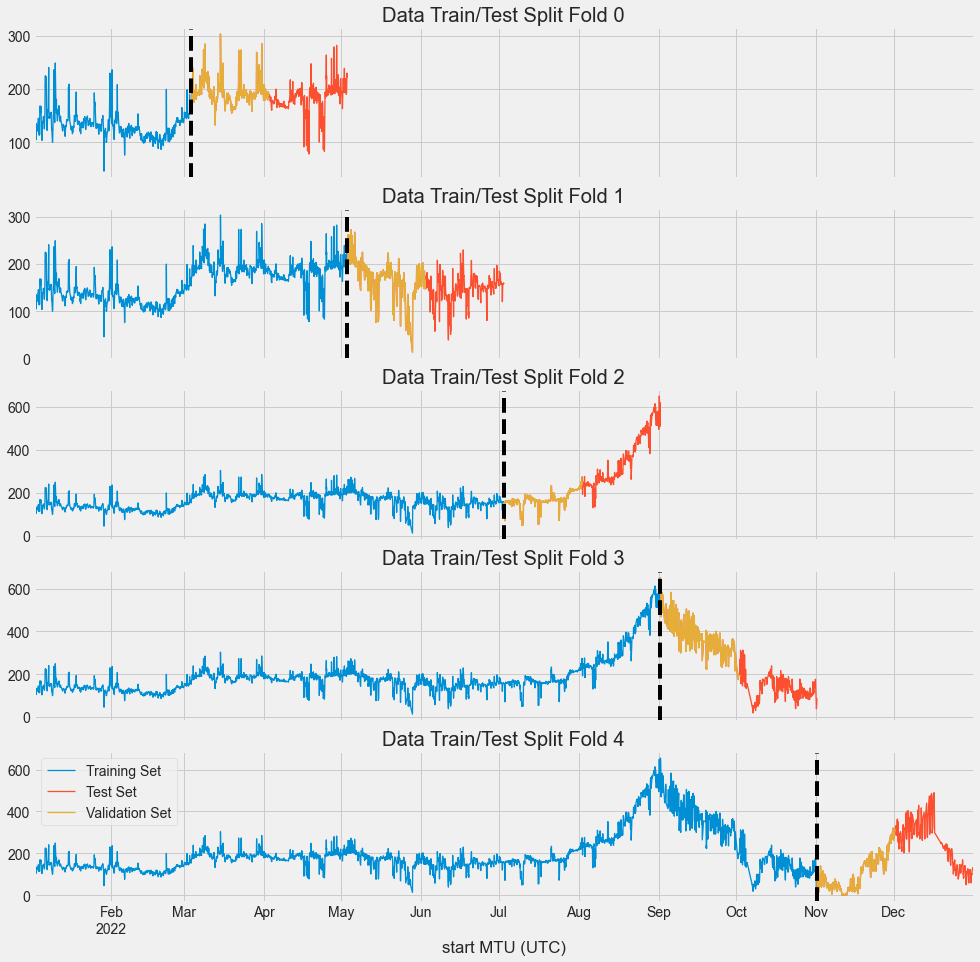

In [128]:
# use a 5-fold cross-validation with each fold representing a period of approximately 73 days.
times_series = TimeSeriesSplit(n_splits=5, gap=0)

fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0

for train_idx, val_idx in times_series.split(df):
    train_data = df.iloc[train_idx]
    test = df.iloc[val_idx]
    val_data, test_data = train_test_split(test, test_size=0.5, shuffle=False)

    train_data[TARGET].plot(ax=axs[fold],
                            label='Training Set', lw= 1.3)

    test[TARGET].plot(ax=axs[fold],
                      label='Test Set', lw= 1.3)

    val_data[TARGET].plot(ax=axs[fold], lw= 1.3,
                          label='Validation Set',
                          title=f'Data Train/Test Split Fold {fold}')

    axs[fold].axvline(test.index.min(), color='black', ls='--')

    fold += 1

plt.legend(loc="best")
plt.show()

### 3.2 Creating x,y for each split (train, test, validation)

In [129]:
# Train dataset
X_train = train_data[all_lagged_feature_names]
y_train = train_data[TARGET]

## Test dataset, used for predicting
X_test = test_data[all_lagged_feature_names]
y_test = test_data[TARGET]

# validation set , used for eval_set() method in the XGBoost library . Very useful tool in XGBoost for monitoring model performance and preventing overfittin during model training.
X_valid= val_data[all_lagged_feature_names]
y_valid = val_data[TARGET]

# 4. Normalize the input features

In [130]:
# Standardize the X-test data
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)

# 5. training and validating

### 5.1 Creating defualt XGBoost Reggressor

In [131]:

default_reg = xgb.XGBRegressor (
    learning_rate =0.1,
    n_estimators=1000,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    nthread=4,
    scale_pos_weight=1,
    seed=27)

### 5.1 Tarining model using defualt XGBoost Reggressor

In [132]:
 ## Fit the model using train data and do simple evaluation using validation set
history = default_reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        eval_metric = 'rmse',
        verbose=False)
# Access the performance metrics
train_scores = history.evals_result()['validation_0']['rmse']
valid_scores = history.evals_result()['validation_1']['rmse']

# Print the performance metrics at the last epoch
print(f"Train RMSE: {train_scores[-1]:.2f}")
print(f"Valid RMSE: {valid_scores[-1]:.2f}")

# Print the performance metrics at the last epoch for fitting and evaluation
print("*  fitting and evaluation train scores :", train_scores[::200])
print("*  fitting and evaluation valid_scores :" ,valid_scores[::200])


C:\Users\Isak\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


ValueError: training data did not have the following fields: Day-ahead Price _EUR/MWh_ BZN|NO1_lag_1, Day-ahead Price _EUR/MWh_ BZN|NO1_lag_2, Day-ahead Price _EUR/MWh_ BZN|NO1_lag_3, Day-ahead Price _EUR/MWh_ BZN|NO1_lag_4, Day-ahead Price _EUR/MWh_ BZN|NO1_lag_5, Day-ahead Price _EUR/MWh_ BZN|NO1_lag_6, Day-ahead Price _EUR/MWh_ BZN|NO1_lag_7, Day-ahead Price _EUR/MWh_ BZN|NO1_lag_8, Day-ahead Price _EUR/MWh_ BZN|NO1_lag_9, Day-ahead Price _EUR/MWh_ BZN|NO1_lag_10, Day-ahead Price _EUR/MWh_ BZN|NO1_lag_11, Day-ahead Price _EUR/MWh_ BZN|NO1_lag_12, Day-ahead Price _EUR/MWh_ BZN|NO1_lag_13, Day-ahead Price _EUR/MWh_ BZN|NO1_lag_14, Day-ahead Price _EUR/MWh_ BZN|NO1_lag_15, Day-ahead Price _EUR/MWh_ BZN|NO1_lag_16, Day-ahead Price _EUR/MWh_ BZN|NO1_lag_17, Day-ahead Price _EUR/MWh_ BZN|NO1_lag_18, Day-ahead Price _EUR/MWh_ BZN|NO1_lag_19, Day-ahead Price _EUR/MWh_ BZN|NO1_lag_20, Day-ahead Price _EUR/MWh_ BZN|NO1_lag_21, Day-ahead Price _EUR/MWh_ BZN|NO1_lag_22, Day-ahead Price _EUR/MWh_ BZN|NO1_lag_23, Day-ahead Price _EUR/MWh_ BZN|NO1_lag_24, Day-ahead Price _EUR/MWh_ BZN|NO3_lag_1, Day-ahead Price _EUR/MWh_ BZN|NO3_lag_2, Day-ahead Price _EUR/MWh_ BZN|NO3_lag_3, Day-ahead Price _EUR/MWh_ BZN|NO3_lag_4, Day-ahead Price _EUR/MWh_ BZN|NO3_lag_5, Day-ahead Price _EUR/MWh_ BZN|NO3_lag_6, Day-ahead Price _EUR/MWh_ BZN|NO3_lag_7, Day-ahead Price _EUR/MWh_ BZN|NO3_lag_8, Day-ahead Price _EUR/MWh_ BZN|NO3_lag_9, Day-ahead Price _EUR/MWh_ BZN|NO3_lag_10, Day-ahead Price _EUR/MWh_ BZN|NO3_lag_11, Day-ahead Price _EUR/MWh_ BZN|NO3_lag_12, Day-ahead Price _EUR/MWh_ BZN|NO3_lag_13, Day-ahead Price _EUR/MWh_ BZN|NO3_lag_14, Day-ahead Price _EUR/MWh_ BZN|NO3_lag_15, Day-ahead Price _EUR/MWh_ BZN|NO3_lag_16, Day-ahead Price _EUR/MWh_ BZN|NO3_lag_17, Day-ahead Price _EUR/MWh_ BZN|NO3_lag_18, Day-ahead Price _EUR/MWh_ BZN|NO3_lag_19, Day-ahead Price _EUR/MWh_ BZN|NO3_lag_20, Day-ahead Price _EUR/MWh_ BZN|NO3_lag_21, Day-ahead Price _EUR/MWh_ BZN|NO3_lag_22, Day-ahead Price _EUR/MWh_ BZN|NO3_lag_23, Day-ahead Price _EUR/MWh_ BZN|NO3_lag_24, Day-ahead Price _EUR/MWh_ BZN|NO5_lag_1, Day-ahead Price _EUR/MWh_ BZN|NO5_lag_2, Day-ahead Price _EUR/MWh_ BZN|NO5_lag_3, Day-ahead Price _EUR/MWh_ BZN|NO5_lag_4, Day-ahead Price _EUR/MWh_ BZN|NO5_lag_5, Day-ahead Price _EUR/MWh_ BZN|NO5_lag_6, Day-ahead Price _EUR/MWh_ BZN|NO5_lag_7, Day-ahead Price _EUR/MWh_ BZN|NO5_lag_8, Day-ahead Price _EUR/MWh_ BZN|NO5_lag_9, Day-ahead Price _EUR/MWh_ BZN|NO5_lag_10, Day-ahead Price _EUR/MWh_ BZN|NO5_lag_11, Day-ahead Price _EUR/MWh_ BZN|NO5_lag_12, Day-ahead Price _EUR/MWh_ BZN|NO5_lag_13, Day-ahead Price _EUR/MWh_ BZN|NO5_lag_14, Day-ahead Price _EUR/MWh_ BZN|NO5_lag_15, Day-ahead Price _EUR/MWh_ BZN|NO5_lag_16, Day-ahead Price _EUR/MWh_ BZN|NO5_lag_17, Day-ahead Price _EUR/MWh_ BZN|NO5_lag_18, Day-ahead Price _EUR/MWh_ BZN|NO5_lag_19, Day-ahead Price _EUR/MWh_ BZN|NO5_lag_20, Day-ahead Price _EUR/MWh_ BZN|NO5_lag_21, Day-ahead Price _EUR/MWh_ BZN|NO5_lag_22, Day-ahead Price _EUR/MWh_ BZN|NO5_lag_23, Day-ahead Price _EUR/MWh_ BZN|NO5_lag_24, Day-ahead Price _EUR/MWh_ BZN|SE3_lag_1, Day-ahead Price _EUR/MWh_ BZN|SE3_lag_2, Day-ahead Price _EUR/MWh_ BZN|SE3_lag_3, Day-ahead Price _EUR/MWh_ BZN|SE3_lag_4, Day-ahead Price _EUR/MWh_ BZN|SE3_lag_5, Day-ahead Price _EUR/MWh_ BZN|SE3_lag_6, Day-ahead Price _EUR/MWh_ BZN|SE3_lag_7, Day-ahead Price _EUR/MWh_ BZN|SE3_lag_8, Day-ahead Price _EUR/MWh_ BZN|SE3_lag_9, Day-ahead Price _EUR/MWh_ BZN|SE3_lag_10, Day-ahead Price _EUR/MWh_ BZN|SE3_lag_11, Day-ahead Price _EUR/MWh_ BZN|SE3_lag_12, Day-ahead Price _EUR/MWh_ BZN|SE3_lag_13, Day-ahead Price _EUR/MWh_ BZN|SE3_lag_14, Day-ahead Price _EUR/MWh_ BZN|SE3_lag_15, Day-ahead Price _EUR/MWh_ BZN|SE3_lag_16, Day-ahead Price _EUR/MWh_ BZN|SE3_lag_17, Day-ahead Price _EUR/MWh_ BZN|SE3_lag_18, Day-ahead Price _EUR/MWh_ BZN|SE3_lag_19, Day-ahead Price _EUR/MWh_ BZN|SE3_lag_20, Day-ahead Price _EUR/MWh_ BZN|SE3_lag_21, Day-ahead Price _EUR/MWh_ BZN|SE3_lag_22, Day-ahead Price _EUR/MWh_ BZN|SE3_lag_23, Day-ahead Price _EUR/MWh_ BZN|SE3_lag_24, Actual Total Load _MW_ - BZN|NO5_lag_1, Actual Total Load _MW_ - BZN|NO5_lag_2, Actual Total Load _MW_ - BZN|NO5_lag_3, Actual Total Load _MW_ - BZN|NO5_lag_4, Actual Total Load _MW_ - BZN|NO5_lag_5, Actual Total Load _MW_ - BZN|NO5_lag_6, Actual Total Load _MW_ - BZN|NO5_lag_7, Actual Total Load _MW_ - BZN|NO5_lag_8, Actual Total Load _MW_ - BZN|NO5_lag_9, Actual Total Load _MW_ - BZN|NO5_lag_10, Actual Total Load _MW_ - BZN|NO5_lag_11, Actual Total Load _MW_ - BZN|NO5_lag_12, Actual Total Load _MW_ - BZN|NO5_lag_13, Actual Total Load _MW_ - BZN|NO5_lag_14, Actual Total Load _MW_ - BZN|NO5_lag_15, Actual Total Load _MW_ - BZN|NO5_lag_16, Actual Total Load _MW_ - BZN|NO5_lag_17, Actual Total Load _MW_ - BZN|NO5_lag_18, Actual Total Load _MW_ - BZN|NO5_lag_19, Actual Total Load _MW_ - BZN|NO5_lag_20, Actual Total Load _MW_ - BZN|NO5_lag_21, Actual Total Load _MW_ - BZN|NO5_lag_22, Actual Total Load _MW_ - BZN|NO5_lag_23, Actual Total Load _MW_ - BZN|NO5_lag_24, Hydro Run-of-river and poundage - BZN|NO1_lag_1, Hydro Run-of-river and poundage - BZN|NO1_lag_2, Hydro Run-of-river and poundage - BZN|NO1_lag_3, Hydro Run-of-river and poundage - BZN|NO1_lag_4, Hydro Run-of-river and poundage - BZN|NO1_lag_5, Hydro Run-of-river and poundage - BZN|NO1_lag_6, Hydro Run-of-river and poundage - BZN|NO1_lag_7, Hydro Run-of-river and poundage - BZN|NO1_lag_8, Hydro Run-of-river and poundage - BZN|NO1_lag_9, Hydro Run-of-river and poundage - BZN|NO1_lag_10, Hydro Run-of-river and poundage - BZN|NO1_lag_11, Hydro Run-of-river and poundage - BZN|NO1_lag_12, Hydro Run-of-river and poundage - BZN|NO1_lag_13, Hydro Run-of-river and poundage - BZN|NO1_lag_14, Hydro Run-of-river and poundage - BZN|NO1_lag_15, Hydro Run-of-river and poundage - BZN|NO1_lag_16, Hydro Run-of-river and poundage - BZN|NO1_lag_17, Hydro Run-of-river and poundage - BZN|NO1_lag_18, Hydro Run-of-river and poundage - BZN|NO1_lag_19, Hydro Run-of-river and poundage - BZN|NO1_lag_20, Hydro Run-of-river and poundage - BZN|NO1_lag_21, Hydro Run-of-river and poundage - BZN|NO1_lag_22, Hydro Run-of-river and poundage - BZN|NO1_lag_23, Hydro Run-of-river and poundage - BZN|NO1_lag_24, Hydro Water Reservoir - BZN|NO1_lag_1, Hydro Water Reservoir - BZN|NO1_lag_2, Hydro Water Reservoir - BZN|NO1_lag_3, Hydro Water Reservoir - BZN|NO1_lag_4, Hydro Water Reservoir - BZN|NO1_lag_5, Hydro Water Reservoir - BZN|NO1_lag_6, Hydro Water Reservoir - BZN|NO1_lag_7, Hydro Water Reservoir - BZN|NO1_lag_8, Hydro Water Reservoir - BZN|NO1_lag_9, Hydro Water Reservoir - BZN|NO1_lag_10, Hydro Water Reservoir - BZN|NO1_lag_11, Hydro Water Reservoir - BZN|NO1_lag_12, Hydro Water Reservoir - BZN|NO1_lag_13, Hydro Water Reservoir - BZN|NO1_lag_14, Hydro Water Reservoir - BZN|NO1_lag_15, Hydro Water Reservoir - BZN|NO1_lag_16, Hydro Water Reservoir - BZN|NO1_lag_17, Hydro Water Reservoir - BZN|NO1_lag_18, Hydro Water Reservoir - BZN|NO1_lag_19, Hydro Water Reservoir - BZN|NO1_lag_20, Hydro Water Reservoir - BZN|NO1_lag_21, Hydro Water Reservoir - BZN|NO1_lag_22, Hydro Water Reservoir - BZN|NO1_lag_23, Hydro Water Reservoir - BZN|NO1_lag_24, Wind Onshore - BZN|NO1_lag_1, Wind Onshore - BZN|NO1_lag_2, Wind Onshore - BZN|NO1_lag_3, Wind Onshore - BZN|NO1_lag_4, Wind Onshore - BZN|NO1_lag_5, Wind Onshore - BZN|NO1_lag_6, Wind Onshore - BZN|NO1_lag_7, Wind Onshore - BZN|NO1_lag_8, Wind Onshore - BZN|NO1_lag_9, Wind Onshore - BZN|NO1_lag_10, Wind Onshore - BZN|NO1_lag_11, Wind Onshore - BZN|NO1_lag_12, Wind Onshore - BZN|NO1_lag_13, Wind Onshore - BZN|NO1_lag_14, Wind Onshore - BZN|NO1_lag_15, Wind Onshore - BZN|NO1_lag_16, Wind Onshore - BZN|NO1_lag_17, Wind Onshore - BZN|NO1_lag_18, Wind Onshore - BZN|NO1_lag_19, Wind Onshore - BZN|NO1_lag_20, Wind Onshore - BZN|NO1_lag_21, Wind Onshore - BZN|NO1_lag_22, Wind Onshore - BZN|NO1_lag_23, Wind Onshore - BZN|NO1_lag_24, Hydro Pumped Storage Aggregated- BZN|NO2_lag_1, Hydro Pumped Storage Aggregated- BZN|NO2_lag_2, Hydro Pumped Storage Aggregated- BZN|NO2_lag_3, Hydro Pumped Storage Aggregated- BZN|NO2_lag_4, Hydro Pumped Storage Aggregated- BZN|NO2_lag_5, Hydro Pumped Storage Aggregated- BZN|NO2_lag_6, Hydro Pumped Storage Aggregated- BZN|NO2_lag_7, Hydro Pumped Storage Aggregated- BZN|NO2_lag_8, Hydro Pumped Storage Aggregated- BZN|NO2_lag_9, Hydro Pumped Storage Aggregated- BZN|NO2_lag_10, Hydro Pumped Storage Aggregated- BZN|NO2_lag_11, Hydro Pumped Storage Aggregated- BZN|NO2_lag_12, Hydro Pumped Storage Aggregated- BZN|NO2_lag_13, Hydro Pumped Storage Aggregated- BZN|NO2_lag_14, Hydro Pumped Storage Aggregated- BZN|NO2_lag_15, Hydro Pumped Storage Aggregated- BZN|NO2_lag_16, Hydro Pumped Storage Aggregated- BZN|NO2_lag_17, Hydro Pumped Storage Aggregated- BZN|NO2_lag_18, Hydro Pumped Storage Aggregated- BZN|NO2_lag_19, Hydro Pumped Storage Aggregated- BZN|NO2_lag_20, Hydro Pumped Storage Aggregated- BZN|NO2_lag_21, Hydro Pumped Storage Aggregated- BZN|NO2_lag_22, Hydro Pumped Storage Aggregated- BZN|NO2_lag_23, Hydro Pumped Storage Aggregated- BZN|NO2_lag_24, Hydro Run-of-river and poundage - BZN|NO2_lag_1, Hydro Run-of-river and poundage - BZN|NO2_lag_2, Hydro Run-of-river and poundage - BZN|NO2_lag_3, Hydro Run-of-river and poundage - BZN|NO2_lag_4, Hydro Run-of-river and poundage - BZN|NO2_lag_5, Hydro Run-of-river and poundage - BZN|NO2_lag_6, Hydro Run-of-river and poundage - BZN|NO2_lag_7, Hydro Run-of-river and poundage - BZN|NO2_lag_8, Hydro Run-of-river and poundage - BZN|NO2_lag_9, Hydro Run-of-river and poundage - BZN|NO2_lag_10, Hydro Run-of-river and poundage - BZN|NO2_lag_11, Hydro Run-of-river and poundage - BZN|NO2_lag_12, Hydro Run-of-river and poundage - BZN|NO2_lag_13, Hydro Run-of-river and poundage - BZN|NO2_lag_14, Hydro Run-of-river and poundage - BZN|NO2_lag_15, Hydro Run-of-river and poundage - BZN|NO2_lag_16, Hydro Run-of-river and poundage - BZN|NO2_lag_17, Hydro Run-of-river and poundage - BZN|NO2_lag_18, Hydro Run-of-river and poundage - BZN|NO2_lag_19, Hydro Run-of-river and poundage - BZN|NO2_lag_20, Hydro Run-of-river and poundage - BZN|NO2_lag_21, Hydro Run-of-river and poundage - BZN|NO2_lag_22, Hydro Run-of-river and poundage - BZN|NO2_lag_23, Hydro Run-of-river and poundage - BZN|NO2_lag_24, Hydro Water Reservoir - BZN|NO2_lag_1, Hydro Water Reservoir - BZN|NO2_lag_2, Hydro Water Reservoir - BZN|NO2_lag_3, Hydro Water Reservoir - BZN|NO2_lag_4, Hydro Water Reservoir - BZN|NO2_lag_5, Hydro Water Reservoir - BZN|NO2_lag_6, Hydro Water Reservoir - BZN|NO2_lag_7, Hydro Water Reservoir - BZN|NO2_lag_8, Hydro Water Reservoir - BZN|NO2_lag_9, Hydro Water Reservoir - BZN|NO2_lag_10, Hydro Water Reservoir - BZN|NO2_lag_11, Hydro Water Reservoir - BZN|NO2_lag_12, Hydro Water Reservoir - BZN|NO2_lag_13, Hydro Water Reservoir - BZN|NO2_lag_14, Hydro Water Reservoir - BZN|NO2_lag_15, Hydro Water Reservoir - BZN|NO2_lag_16, Hydro Water Reservoir - BZN|NO2_lag_17, Hydro Water Reservoir - BZN|NO2_lag_18, Hydro Water Reservoir - BZN|NO2_lag_19, Hydro Water Reservoir - BZN|NO2_lag_20, Hydro Water Reservoir - BZN|NO2_lag_21, Hydro Water Reservoir - BZN|NO2_lag_22, Hydro Water Reservoir - BZN|NO2_lag_23, Hydro Water Reservoir - BZN|NO2_lag_24, Waste - BZN|NO2_lag_1, Waste - BZN|NO2_lag_2, Waste - BZN|NO2_lag_3, Waste - BZN|NO2_lag_4, Waste - BZN|NO2_lag_5, Waste - BZN|NO2_lag_6, Waste - BZN|NO2_lag_7, Waste - BZN|NO2_lag_8, Waste - BZN|NO2_lag_9, Waste - BZN|NO2_lag_10, Waste - BZN|NO2_lag_11, Waste - BZN|NO2_lag_12, Waste - BZN|NO2_lag_13, Waste - BZN|NO2_lag_14, Waste - BZN|NO2_lag_15, Waste - BZN|NO2_lag_16, Waste - BZN|NO2_lag_17, Waste - BZN|NO2_lag_18, Waste - BZN|NO2_lag_19, Waste - BZN|NO2_lag_20, Waste - BZN|NO2_lag_21, Waste - BZN|NO2_lag_22, Waste - BZN|NO2_lag_23, Waste - BZN|NO2_lag_24, Wind Onshore - BZN|NO2_lag_1, Wind Onshore - BZN|NO2_lag_2, Wind Onshore - BZN|NO2_lag_3, Wind Onshore - BZN|NO2_lag_4, Wind Onshore - BZN|NO2_lag_5, Wind Onshore - BZN|NO2_lag_6, Wind Onshore - BZN|NO2_lag_7, Wind Onshore - BZN|NO2_lag_8, Wind Onshore - BZN|NO2_lag_9, Wind Onshore - BZN|NO2_lag_10, Wind Onshore - BZN|NO2_lag_11, Wind Onshore - BZN|NO2_lag_12, Wind Onshore - BZN|NO2_lag_13, Wind Onshore - BZN|NO2_lag_14, Wind Onshore - BZN|NO2_lag_15, Wind Onshore - BZN|NO2_lag_16, Wind Onshore - BZN|NO2_lag_17, Wind Onshore - BZN|NO2_lag_18, Wind Onshore - BZN|NO2_lag_19, Wind Onshore - BZN|NO2_lag_20, Wind Onshore - BZN|NO2_lag_21, Wind Onshore - BZN|NO2_lag_22, Wind Onshore - BZN|NO2_lag_23, Wind Onshore - BZN|NO2_lag_24, Hydro Pumped Storage Aggregated- BZN|NO3_lag_1, Hydro Pumped Storage Aggregated- BZN|NO3_lag_2, Hydro Pumped Storage Aggregated- BZN|NO3_lag_3, Hydro Pumped Storage Aggregated- BZN|NO3_lag_4, Hydro Pumped Storage Aggregated- BZN|NO3_lag_5, Hydro Pumped Storage Aggregated- BZN|NO3_lag_6, Hydro Pumped Storage Aggregated- BZN|NO3_lag_7, Hydro Pumped Storage Aggregated- BZN|NO3_lag_8, Hydro Pumped Storage Aggregated- BZN|NO3_lag_9, Hydro Pumped Storage Aggregated- BZN|NO3_lag_10, Hydro Pumped Storage Aggregated- BZN|NO3_lag_11, Hydro Pumped Storage Aggregated- BZN|NO3_lag_12, Hydro Pumped Storage Aggregated- BZN|NO3_lag_13, Hydro Pumped Storage Aggregated- BZN|NO3_lag_14, Hydro Pumped Storage Aggregated- BZN|NO3_lag_15, Hydro Pumped Storage Aggregated- BZN|NO3_lag_16, Hydro Pumped Storage Aggregated- BZN|NO3_lag_17, Hydro Pumped Storage Aggregated- BZN|NO3_lag_18, Hydro Pumped Storage Aggregated- BZN|NO3_lag_19, Hydro Pumped Storage Aggregated- BZN|NO3_lag_20, Hydro Pumped Storage Aggregated- BZN|NO3_lag_21, Hydro Pumped Storage Aggregated- BZN|NO3_lag_22, Hydro Pumped Storage Aggregated- BZN|NO3_lag_23, Hydro Pumped Storage Aggregated- BZN|NO3_lag_24, Hydro Run-of-river and poundage - BZN|NO3_lag_1, Hydro Run-of-river and poundage - BZN|NO3_lag_2, Hydro Run-of-river and poundage - BZN|NO3_lag_3, Hydro Run-of-river and poundage - BZN|NO3_lag_4, Hydro Run-of-river and poundage - BZN|NO3_lag_5, Hydro Run-of-river and poundage - BZN|NO3_lag_6, Hydro Run-of-river and poundage - BZN|NO3_lag_7, Hydro Run-of-river and poundage - BZN|NO3_lag_8, Hydro Run-of-river and poundage - BZN|NO3_lag_9, Hydro Run-of-river and poundage - BZN|NO3_lag_10, Hydro Run-of-river and poundage - BZN|NO3_lag_11, Hydro Run-of-river and poundage - BZN|NO3_lag_12, Hydro Run-of-river and poundage - BZN|NO3_lag_13, Hydro Run-of-river and poundage - BZN|NO3_lag_14, Hydro Run-of-river and poundage - BZN|NO3_lag_15, Hydro Run-of-river and poundage - BZN|NO3_lag_16, Hydro Run-of-river and poundage - BZN|NO3_lag_17, Hydro Run-of-river and poundage - BZN|NO3_lag_18, Hydro Run-of-river and poundage - BZN|NO3_lag_19, Hydro Run-of-river and poundage - BZN|NO3_lag_20, Hydro Run-of-river and poundage - BZN|NO3_lag_21, Hydro Run-of-river and poundage - BZN|NO3_lag_22, Hydro Run-of-river and poundage - BZN|NO3_lag_23, Hydro Run-of-river and poundage - BZN|NO3_lag_24, Hydro Water Reservoir - BZN|NO3_lag_1, Hydro Water Reservoir - BZN|NO3_lag_2, Hydro Water Reservoir - BZN|NO3_lag_3, Hydro Water Reservoir - BZN|NO3_lag_4, Hydro Water Reservoir - BZN|NO3_lag_5, Hydro Water Reservoir - BZN|NO3_lag_6, Hydro Water Reservoir - BZN|NO3_lag_7, Hydro Water Reservoir - BZN|NO3_lag_8, Hydro Water Reservoir - BZN|NO3_lag_9, Hydro Water Reservoir - BZN|NO3_lag_10, Hydro Water Reservoir - BZN|NO3_lag_11, Hydro Water Reservoir - BZN|NO3_lag_12, Hydro Water Reservoir - BZN|NO3_lag_13, Hydro Water Reservoir - BZN|NO3_lag_14, Hydro Water Reservoir - BZN|NO3_lag_15, Hydro Water Reservoir - BZN|NO3_lag_16, Hydro Water Reservoir - BZN|NO3_lag_17, Hydro Water Reservoir - BZN|NO3_lag_18, Hydro Water Reservoir - BZN|NO3_lag_19, Hydro Water Reservoir - BZN|NO3_lag_20, Hydro Water Reservoir - BZN|NO3_lag_21, Hydro Water Reservoir - BZN|NO3_lag_22, Hydro Water Reservoir - BZN|NO3_lag_23, Hydro Water Reservoir - BZN|NO3_lag_24, Other renewable - BZN|NO3_lag_1, Other renewable - BZN|NO3_lag_2, Other renewable - BZN|NO3_lag_3, Other renewable - BZN|NO3_lag_4, Other renewable - BZN|NO3_lag_5, Other renewable - BZN|NO3_lag_6, Other renewable - BZN|NO3_lag_7, Other renewable - BZN|NO3_lag_8, Other renewable - BZN|NO3_lag_9, Other renewable - BZN|NO3_lag_10, Other renewable - BZN|NO3_lag_11, Other renewable - BZN|NO3_lag_12, Other renewable - BZN|NO3_lag_13, Other renewable - BZN|NO3_lag_14, Other renewable - BZN|NO3_lag_15, Other renewable - BZN|NO3_lag_16, Other renewable - BZN|NO3_lag_17, Other renewable - BZN|NO3_lag_18, Other renewable - BZN|NO3_lag_19, Other renewable - BZN|NO3_lag_20, Other renewable - BZN|NO3_lag_21, Other renewable - BZN|NO3_lag_22, Other renewable - BZN|NO3_lag_23, Other renewable - BZN|NO3_lag_24, Wind Onshore - BZN|NO3_lag_1, Wind Onshore - BZN|NO3_lag_2, Wind Onshore - BZN|NO3_lag_3, Wind Onshore - BZN|NO3_lag_4, Wind Onshore - BZN|NO3_lag_5, Wind Onshore - BZN|NO3_lag_6, Wind Onshore - BZN|NO3_lag_7, Wind Onshore - BZN|NO3_lag_8, Wind Onshore - BZN|NO3_lag_9, Wind Onshore - BZN|NO3_lag_10, Wind Onshore - BZN|NO3_lag_11, Wind Onshore - BZN|NO3_lag_12, Wind Onshore - BZN|NO3_lag_13, Wind Onshore - BZN|NO3_lag_14, Wind Onshore - BZN|NO3_lag_15, Wind Onshore - BZN|NO3_lag_16, Wind Onshore - BZN|NO3_lag_17, Wind Onshore - BZN|NO3_lag_18, Wind Onshore - BZN|NO3_lag_19, Wind Onshore - BZN|NO3_lag_20, Wind Onshore - BZN|NO3_lag_21, Wind Onshore - BZN|NO3_lag_22, Wind Onshore - BZN|NO3_lag_23, Wind Onshore - BZN|NO3_lag_24, Fossil Gas - BZN|NO5_lag_1, Fossil Gas - BZN|NO5_lag_2, Fossil Gas - BZN|NO5_lag_3, Fossil Gas - BZN|NO5_lag_4, Fossil Gas - BZN|NO5_lag_5, Fossil Gas - BZN|NO5_lag_6, Fossil Gas - BZN|NO5_lag_7, Fossil Gas - BZN|NO5_lag_8, Fossil Gas - BZN|NO5_lag_9, Fossil Gas - BZN|NO5_lag_10, Fossil Gas - BZN|NO5_lag_11, Fossil Gas - BZN|NO5_lag_12, Fossil Gas - BZN|NO5_lag_13, Fossil Gas - BZN|NO5_lag_14, Fossil Gas - BZN|NO5_lag_15, Fossil Gas - BZN|NO5_lag_16, Fossil Gas - BZN|NO5_lag_17, Fossil Gas - BZN|NO5_lag_18, Fossil Gas - BZN|NO5_lag_19, Fossil Gas - BZN|NO5_lag_20, Fossil Gas - BZN|NO5_lag_21, Fossil Gas - BZN|NO5_lag_22, Fossil Gas - BZN|NO5_lag_23, Fossil Gas - BZN|NO5_lag_24, Hydro Pumped Storage Aggregated- BZN|NO5_lag_1, Hydro Pumped Storage Aggregated- BZN|NO5_lag_2, Hydro Pumped Storage Aggregated- BZN|NO5_lag_3, Hydro Pumped Storage Aggregated- BZN|NO5_lag_4, Hydro Pumped Storage Aggregated- BZN|NO5_lag_5, Hydro Pumped Storage Aggregated- BZN|NO5_lag_6, Hydro Pumped Storage Aggregated- BZN|NO5_lag_7, Hydro Pumped Storage Aggregated- BZN|NO5_lag_8, Hydro Pumped Storage Aggregated- BZN|NO5_lag_9, Hydro Pumped Storage Aggregated- BZN|NO5_lag_10, Hydro Pumped Storage Aggregated- BZN|NO5_lag_11, Hydro Pumped Storage Aggregated- BZN|NO5_lag_12, Hydro Pumped Storage Aggregated- BZN|NO5_lag_13, Hydro Pumped Storage Aggregated- BZN|NO5_lag_14, Hydro Pumped Storage Aggregated- BZN|NO5_lag_15, Hydro Pumped Storage Aggregated- BZN|NO5_lag_16, Hydro Pumped Storage Aggregated- BZN|NO5_lag_17, Hydro Pumped Storage Aggregated- BZN|NO5_lag_18, Hydro Pumped Storage Aggregated- BZN|NO5_lag_19, Hydro Pumped Storage Aggregated- BZN|NO5_lag_20, Hydro Pumped Storage Aggregated- BZN|NO5_lag_21, Hydro Pumped Storage Aggregated- BZN|NO5_lag_22, Hydro Pumped Storage Aggregated- BZN|NO5_lag_23, Hydro Pumped Storage Aggregated- BZN|NO5_lag_24, Hydro Run-of-river and poundage - BZN|NO5_lag_1, Hydro Run-of-river and poundage - BZN|NO5_lag_2, Hydro Run-of-river and poundage - BZN|NO5_lag_3, Hydro Run-of-river and poundage - BZN|NO5_lag_4, Hydro Run-of-river and poundage - BZN|NO5_lag_5, Hydro Run-of-river and poundage - BZN|NO5_lag_6, Hydro Run-of-river and poundage - BZN|NO5_lag_7, Hydro Run-of-river and poundage - BZN|NO5_lag_8, Hydro Run-of-river and poundage - BZN|NO5_lag_9, Hydro Run-of-river and poundage - BZN|NO5_lag_10, Hydro Run-of-river and poundage - BZN|NO5_lag_11, Hydro Run-of-river and poundage - BZN|NO5_lag_12, Hydro Run-of-river and poundage - BZN|NO5_lag_13, Hydro Run-of-river and poundage - BZN|NO5_lag_14, Hydro Run-of-river and poundage - BZN|NO5_lag_15, Hydro Run-of-river and poundage - BZN|NO5_lag_16, Hydro Run-of-river and poundage - BZN|NO5_lag_17, Hydro Run-of-river and poundage - BZN|NO5_lag_18, Hydro Run-of-river and poundage - BZN|NO5_lag_19, Hydro Run-of-river and poundage - BZN|NO5_lag_20, Hydro Run-of-river and poundage - BZN|NO5_lag_21, Hydro Run-of-river and poundage - BZN|NO5_lag_22, Hydro Run-of-river and poundage - BZN|NO5_lag_23, Hydro Run-of-river and poundage - BZN|NO5_lag_24, Waste - BZN|NO5_lag_1, Waste - BZN|NO5_lag_2, Waste - BZN|NO5_lag_3, Waste - BZN|NO5_lag_4, Waste - BZN|NO5_lag_5, Waste - BZN|NO5_lag_6, Waste - BZN|NO5_lag_7, Waste - BZN|NO5_lag_8, Waste - BZN|NO5_lag_9, Waste - BZN|NO5_lag_10, Waste - BZN|NO5_lag_11, Waste - BZN|NO5_lag_12, Waste - BZN|NO5_lag_13, Waste - BZN|NO5_lag_14, Waste - BZN|NO5_lag_15, Waste - BZN|NO5_lag_16, Waste - BZN|NO5_lag_17, Waste - BZN|NO5_lag_18, Waste - BZN|NO5_lag_19, Waste - BZN|NO5_lag_20, Waste - BZN|NO5_lag_21, Waste - BZN|NO5_lag_22, Waste - BZN|NO5_lag_23, Waste - BZN|NO5_lag_24, Hydro Water Reservoir - BZN|SE3_lag_1, Hydro Water Reservoir - BZN|SE3_lag_2, Hydro Water Reservoir - BZN|SE3_lag_3, Hydro Water Reservoir - BZN|SE3_lag_4, Hydro Water Reservoir - BZN|SE3_lag_5, Hydro Water Reservoir - BZN|SE3_lag_6, Hydro Water Reservoir - BZN|SE3_lag_7, Hydro Water Reservoir - BZN|SE3_lag_8, Hydro Water Reservoir - BZN|SE3_lag_9, Hydro Water Reservoir - BZN|SE3_lag_10, Hydro Water Reservoir - BZN|SE3_lag_11, Hydro Water Reservoir - BZN|SE3_lag_12, Hydro Water Reservoir - BZN|SE3_lag_13, Hydro Water Reservoir - BZN|SE3_lag_14, Hydro Water Reservoir - BZN|SE3_lag_15, Hydro Water Reservoir - BZN|SE3_lag_16, Hydro Water Reservoir - BZN|SE3_lag_17, Hydro Water Reservoir - BZN|SE3_lag_18, Hydro Water Reservoir - BZN|SE3_lag_19, Hydro Water Reservoir - BZN|SE3_lag_20, Hydro Water Reservoir - BZN|SE3_lag_21, Hydro Water Reservoir - BZN|SE3_lag_22, Hydro Water Reservoir - BZN|SE3_lag_23, Hydro Water Reservoir - BZN|SE3_lag_24, Nuclear - BZN|SE3_lag_1, Nuclear - BZN|SE3_lag_2, Nuclear - BZN|SE3_lag_3, Nuclear - BZN|SE3_lag_4, Nuclear - BZN|SE3_lag_5, Nuclear - BZN|SE3_lag_6, Nuclear - BZN|SE3_lag_7, Nuclear - BZN|SE3_lag_8, Nuclear - BZN|SE3_lag_9, Nuclear - BZN|SE3_lag_10, Nuclear - BZN|SE3_lag_11, Nuclear - BZN|SE3_lag_12, Nuclear - BZN|SE3_lag_13, Nuclear - BZN|SE3_lag_14, Nuclear - BZN|SE3_lag_15, Nuclear - BZN|SE3_lag_16, Nuclear - BZN|SE3_lag_17, Nuclear - BZN|SE3_lag_18, Nuclear - BZN|SE3_lag_19, Nuclear - BZN|SE3_lag_20, Nuclear - BZN|SE3_lag_21, Nuclear - BZN|SE3_lag_22, Nuclear - BZN|SE3_lag_23, Nuclear - BZN|SE3_lag_24, Solar - BZN|SE3_lag_1, Solar - BZN|SE3_lag_2, Solar - BZN|SE3_lag_3, Solar - BZN|SE3_lag_4, Solar - BZN|SE3_lag_5, Solar - BZN|SE3_lag_6, Solar - BZN|SE3_lag_7, Solar - BZN|SE3_lag_8, Solar - BZN|SE3_lag_9, Solar - BZN|SE3_lag_10, Solar - BZN|SE3_lag_11, Solar - BZN|SE3_lag_12, Solar - BZN|SE3_lag_13, Solar - BZN|SE3_lag_14, Solar - BZN|SE3_lag_15, Solar - BZN|SE3_lag_16, Solar - BZN|SE3_lag_17, Solar - BZN|SE3_lag_18, Solar - BZN|SE3_lag_19, Solar - BZN|SE3_lag_20, Solar - BZN|SE3_lag_21, Solar - BZN|SE3_lag_22, Solar - BZN|SE3_lag_23, Solar - BZN|SE3_lag_24, Wind Onshore - BZN|SE3_lag_1, Wind Onshore - BZN|SE3_lag_2, Wind Onshore - BZN|SE3_lag_3, Wind Onshore - BZN|SE3_lag_4, Wind Onshore - BZN|SE3_lag_5, Wind Onshore - BZN|SE3_lag_6, Wind Onshore - BZN|SE3_lag_7, Wind Onshore - BZN|SE3_lag_8, Wind Onshore - BZN|SE3_lag_9, Wind Onshore - BZN|SE3_lag_10, Wind Onshore - BZN|SE3_lag_11, Wind Onshore - BZN|SE3_lag_12, Wind Onshore - BZN|SE3_lag_13, Wind Onshore - BZN|SE3_lag_14, Wind Onshore - BZN|SE3_lag_15, Wind Onshore - BZN|SE3_lag_16, Wind Onshore - BZN|SE3_lag_17, Wind Onshore - BZN|SE3_lag_18, Wind Onshore - BZN|SE3_lag_19, Wind Onshore - BZN|SE3_lag_20, Wind Onshore - BZN|SE3_lag_21, Wind Onshore - BZN|SE3_lag_22, Wind Onshore - BZN|SE3_lag_23, Wind Onshore - BZN|SE3_lag_24, CBF BZN|NO2 > BZN|NO1 _MW__lag_1, CBF BZN|NO2 > BZN|NO1 _MW__lag_2, CBF BZN|NO2 > BZN|NO1 _MW__lag_3, CBF BZN|NO2 > BZN|NO1 _MW__lag_4, CBF BZN|NO2 > BZN|NO1 _MW__lag_5, CBF BZN|NO2 > BZN|NO1 _MW__lag_6, CBF BZN|NO2 > BZN|NO1 _MW__lag_7, CBF BZN|NO2 > BZN|NO1 _MW__lag_8, CBF BZN|NO2 > BZN|NO1 _MW__lag_9, CBF BZN|NO2 > BZN|NO1 _MW__lag_10, CBF BZN|NO2 > BZN|NO1 _MW__lag_11, CBF BZN|NO2 > BZN|NO1 _MW__lag_12, CBF BZN|NO2 > BZN|NO1 _MW__lag_13, CBF BZN|NO2 > BZN|NO1 _MW__lag_14, CBF BZN|NO2 > BZN|NO1 _MW__lag_15, CBF BZN|NO2 > BZN|NO1 _MW__lag_16, CBF BZN|NO2 > BZN|NO1 _MW__lag_17, CBF BZN|NO2 > BZN|NO1 _MW__lag_18, CBF BZN|NO2 > BZN|NO1 _MW__lag_19, CBF BZN|NO2 > BZN|NO1 _MW__lag_20, CBF BZN|NO2 > BZN|NO1 _MW__lag_21, CBF BZN|NO2 > BZN|NO1 _MW__lag_22, CBF BZN|NO2 > BZN|NO1 _MW__lag_23, CBF BZN|NO2 > BZN|NO1 _MW__lag_24, CBF BZN|NO1 > BZN|NO2 _MW__lag_1, CBF BZN|NO1 > BZN|NO2 _MW__lag_2, CBF BZN|NO1 > BZN|NO2 _MW__lag_3, CBF BZN|NO1 > BZN|NO2 _MW__lag_4, CBF BZN|NO1 > BZN|NO2 _MW__lag_5, CBF BZN|NO1 > BZN|NO2 _MW__lag_6, CBF BZN|NO1 > BZN|NO2 _MW__lag_7, CBF BZN|NO1 > BZN|NO2 _MW__lag_8, CBF BZN|NO1 > BZN|NO2 _MW__lag_9, CBF BZN|NO1 > BZN|NO2 _MW__lag_10, CBF BZN|NO1 > BZN|NO2 _MW__lag_11, CBF BZN|NO1 > BZN|NO2 _MW__lag_12, CBF BZN|NO1 > BZN|NO2 _MW__lag_13, CBF BZN|NO1 > BZN|NO2 _MW__lag_14, CBF BZN|NO1 > BZN|NO2 _MW__lag_15, CBF BZN|NO1 > BZN|NO2 _MW__lag_16, CBF BZN|NO1 > BZN|NO2 _MW__lag_17, CBF BZN|NO1 > BZN|NO2 _MW__lag_18, CBF BZN|NO1 > BZN|NO2 _MW__lag_19, CBF BZN|NO1 > BZN|NO2 _MW__lag_20, CBF BZN|NO1 > BZN|NO2 _MW__lag_21, CBF BZN|NO1 > BZN|NO2 _MW__lag_22, CBF BZN|NO1 > BZN|NO2 _MW__lag_23, CBF BZN|NO1 > BZN|NO2 _MW__lag_24, CBF BZN|NO3 > BZN|NO1 _MW__lag_1, CBF BZN|NO3 > BZN|NO1 _MW__lag_2, CBF BZN|NO3 > BZN|NO1 _MW__lag_3, CBF BZN|NO3 > BZN|NO1 _MW__lag_4, CBF BZN|NO3 > BZN|NO1 _MW__lag_5, CBF BZN|NO3 > BZN|NO1 _MW__lag_6, CBF BZN|NO3 > BZN|NO1 _MW__lag_7, CBF BZN|NO3 > BZN|NO1 _MW__lag_8, CBF BZN|NO3 > BZN|NO1 _MW__lag_9, CBF BZN|NO3 > BZN|NO1 _MW__lag_10, CBF BZN|NO3 > BZN|NO1 _MW__lag_11, CBF BZN|NO3 > BZN|NO1 _MW__lag_12, CBF BZN|NO3 > BZN|NO1 _MW__lag_13, CBF BZN|NO3 > BZN|NO1 _MW__lag_14, CBF BZN|NO3 > BZN|NO1 _MW__lag_15, CBF BZN|NO3 > BZN|NO1 _MW__lag_16, CBF BZN|NO3 > BZN|NO1 _MW__lag_17, CBF BZN|NO3 > BZN|NO1 _MW__lag_18, CBF BZN|NO3 > BZN|NO1 _MW__lag_19, CBF BZN|NO3 > BZN|NO1 _MW__lag_20, CBF BZN|NO3 > BZN|NO1 _MW__lag_21, CBF BZN|NO3 > BZN|NO1 _MW__lag_22, CBF BZN|NO3 > BZN|NO1 _MW__lag_23, CBF BZN|NO3 > BZN|NO1 _MW__lag_24, CBF BZN|NO1 > BZN|NO3 _MW__lag_1, CBF BZN|NO1 > BZN|NO3 _MW__lag_2, CBF BZN|NO1 > BZN|NO3 _MW__lag_3, CBF BZN|NO1 > BZN|NO3 _MW__lag_4, CBF BZN|NO1 > BZN|NO3 _MW__lag_5, CBF BZN|NO1 > BZN|NO3 _MW__lag_6, CBF BZN|NO1 > BZN|NO3 _MW__lag_7, CBF BZN|NO1 > BZN|NO3 _MW__lag_8, CBF BZN|NO1 > BZN|NO3 _MW__lag_9, CBF BZN|NO1 > BZN|NO3 _MW__lag_10, CBF BZN|NO1 > BZN|NO3 _MW__lag_11, CBF BZN|NO1 > BZN|NO3 _MW__lag_12, CBF BZN|NO1 > BZN|NO3 _MW__lag_13, CBF BZN|NO1 > BZN|NO3 _MW__lag_14, CBF BZN|NO1 > BZN|NO3 _MW__lag_15, CBF BZN|NO1 > BZN|NO3 _MW__lag_16, CBF BZN|NO1 > BZN|NO3 _MW__lag_17, CBF BZN|NO1 > BZN|NO3 _MW__lag_18, CBF BZN|NO1 > BZN|NO3 _MW__lag_19, CBF BZN|NO1 > BZN|NO3 _MW__lag_20, CBF BZN|NO1 > BZN|NO3 _MW__lag_21, CBF BZN|NO1 > BZN|NO3 _MW__lag_22, CBF BZN|NO1 > BZN|NO3 _MW__lag_23, CBF BZN|NO1 > BZN|NO3 _MW__lag_24, CBF BZN|NO5 > BZN|NO1 _MW__lag_1, CBF BZN|NO5 > BZN|NO1 _MW__lag_2, CBF BZN|NO5 > BZN|NO1 _MW__lag_3, CBF BZN|NO5 > BZN|NO1 _MW__lag_4, CBF BZN|NO5 > BZN|NO1 _MW__lag_5, CBF BZN|NO5 > BZN|NO1 _MW__lag_6, CBF BZN|NO5 > BZN|NO1 _MW__lag_7, CBF BZN|NO5 > BZN|NO1 _MW__lag_8, CBF BZN|NO5 > BZN|NO1 _MW__lag_9, CBF BZN|NO5 > BZN|NO1 _MW__lag_10, CBF BZN|NO5 > BZN|NO1 _MW__lag_11, CBF BZN|NO5 > BZN|NO1 _MW__lag_12, CBF BZN|NO5 > BZN|NO1 _MW__lag_13, CBF BZN|NO5 > BZN|NO1 _MW__lag_14, CBF BZN|NO5 > BZN|NO1 _MW__lag_15, CBF BZN|NO5 > BZN|NO1 _MW__lag_16, CBF BZN|NO5 > BZN|NO1 _MW__lag_17, CBF BZN|NO5 > BZN|NO1 _MW__lag_18, CBF BZN|NO5 > BZN|NO1 _MW__lag_19, CBF BZN|NO5 > BZN|NO1 _MW__lag_20, CBF BZN|NO5 > BZN|NO1 _MW__lag_21, CBF BZN|NO5 > BZN|NO1 _MW__lag_22, CBF BZN|NO5 > BZN|NO1 _MW__lag_23, CBF BZN|NO5 > BZN|NO1 _MW__lag_24, CBF BZN|NO1 > BZN|NO5 _MW__lag_1, CBF BZN|NO1 > BZN|NO5 _MW__lag_2, CBF BZN|NO1 > BZN|NO5 _MW__lag_3, CBF BZN|NO1 > BZN|NO5 _MW__lag_4, CBF BZN|NO1 > BZN|NO5 _MW__lag_5, CBF BZN|NO1 > BZN|NO5 _MW__lag_6, CBF BZN|NO1 > BZN|NO5 _MW__lag_7, CBF BZN|NO1 > BZN|NO5 _MW__lag_8, CBF BZN|NO1 > BZN|NO5 _MW__lag_9, CBF BZN|NO1 > BZN|NO5 _MW__lag_10, CBF BZN|NO1 > BZN|NO5 _MW__lag_11, CBF BZN|NO1 > BZN|NO5 _MW__lag_12, CBF BZN|NO1 > BZN|NO5 _MW__lag_13, CBF BZN|NO1 > BZN|NO5 _MW__lag_14, CBF BZN|NO1 > BZN|NO5 _MW__lag_15, CBF BZN|NO1 > BZN|NO5 _MW__lag_16, CBF BZN|NO1 > BZN|NO5 _MW__lag_17, CBF BZN|NO1 > BZN|NO5 _MW__lag_18, CBF BZN|NO1 > BZN|NO5 _MW__lag_19, CBF BZN|NO1 > BZN|NO5 _MW__lag_20, CBF BZN|NO1 > BZN|NO5 _MW__lag_21, CBF BZN|NO1 > BZN|NO5 _MW__lag_22, CBF BZN|NO1 > BZN|NO5 _MW__lag_23, CBF BZN|NO1 > BZN|NO5 _MW__lag_24, CBF BZN|SE3 > BZN|NO1 _MW__lag_1, CBF BZN|SE3 > BZN|NO1 _MW__lag_2, CBF BZN|SE3 > BZN|NO1 _MW__lag_3, CBF BZN|SE3 > BZN|NO1 _MW__lag_4, CBF BZN|SE3 > BZN|NO1 _MW__lag_5, CBF BZN|SE3 > BZN|NO1 _MW__lag_6, CBF BZN|SE3 > BZN|NO1 _MW__lag_7, CBF BZN|SE3 > BZN|NO1 _MW__lag_8, CBF BZN|SE3 > BZN|NO1 _MW__lag_9, CBF BZN|SE3 > BZN|NO1 _MW__lag_10, CBF BZN|SE3 > BZN|NO1 _MW__lag_11, CBF BZN|SE3 > BZN|NO1 _MW__lag_12, CBF BZN|SE3 > BZN|NO1 _MW__lag_13, CBF BZN|SE3 > BZN|NO1 _MW__lag_14, CBF BZN|SE3 > BZN|NO1 _MW__lag_15, CBF BZN|SE3 > BZN|NO1 _MW__lag_16, CBF BZN|SE3 > BZN|NO1 _MW__lag_17, CBF BZN|SE3 > BZN|NO1 _MW__lag_18, CBF BZN|SE3 > BZN|NO1 _MW__lag_19, CBF BZN|SE3 > BZN|NO1 _MW__lag_20, CBF BZN|SE3 > BZN|NO1 _MW__lag_21, CBF BZN|SE3 > BZN|NO1 _MW__lag_22, CBF BZN|SE3 > BZN|NO1 _MW__lag_23, CBF BZN|SE3 > BZN|NO1 _MW__lag_24, CBF BZN|NO1 > BZN|SE3 _MW__lag_1, CBF BZN|NO1 > BZN|SE3 _MW__lag_2, CBF BZN|NO1 > BZN|SE3 _MW__lag_3, CBF BZN|NO1 > BZN|SE3 _MW__lag_4, CBF BZN|NO1 > BZN|SE3 _MW__lag_5, CBF BZN|NO1 > BZN|SE3 _MW__lag_6, CBF BZN|NO1 > BZN|SE3 _MW__lag_7, CBF BZN|NO1 > BZN|SE3 _MW__lag_8, CBF BZN|NO1 > BZN|SE3 _MW__lag_9, CBF BZN|NO1 > BZN|SE3 _MW__lag_10, CBF BZN|NO1 > BZN|SE3 _MW__lag_11, CBF BZN|NO1 > BZN|SE3 _MW__lag_12, CBF BZN|NO1 > BZN|SE3 _MW__lag_13, CBF BZN|NO1 > BZN|SE3 _MW__lag_14, CBF BZN|NO1 > BZN|SE3 _MW__lag_15, CBF BZN|NO1 > BZN|SE3 _MW__lag_16, CBF BZN|NO1 > BZN|SE3 _MW__lag_17, CBF BZN|NO1 > BZN|SE3 _MW__lag_18, CBF BZN|NO1 > BZN|SE3 _MW__lag_19, CBF BZN|NO1 > BZN|SE3 _MW__lag_20, CBF BZN|NO1 > BZN|SE3 _MW__lag_21, CBF BZN|NO1 > BZN|SE3 _MW__lag_22, CBF BZN|NO1 > BZN|SE3 _MW__lag_23, CBF BZN|NO1 > BZN|SE3 _MW__lag_24, Stored Energy Value Water Reservoirs and Hydro Storage Plants _MWh_ - BZN|NO3_lag_1, Stored Energy Value Water Reservoirs and Hydro Storage Plants _MWh_ - BZN|NO3_lag_2, Stored Energy Value Water Reservoirs and Hydro Storage Plants _MWh_ - BZN|NO3_lag_3, Stored Energy Value Water Reservoirs and Hydro Storage Plants _MWh_ - BZN|NO3_lag_4, Stored Energy Value Water Reservoirs and Hydro Storage Plants _MWh_ - BZN|NO3_lag_5, Stored Energy Value Water Reservoirs and Hydro Storage Plants _MWh_ - BZN|NO3_lag_6, Stored Energy Value Water Reservoirs and Hydro Storage Plants _MWh_ - BZN|NO3_lag_7, Stored Energy Value Water Reservoirs and Hydro Storage Plants _MWh_ - BZN|NO3_lag_8, Stored Energy Value Water Reservoirs and Hydro Storage Plants _MWh_ - BZN|NO3_lag_9, Stored Energy Value Water Reservoirs and Hydro Storage Plants _MWh_ - BZN|NO3_lag_10, Stored Energy Value Water Reservoirs and Hydro Storage Plants _MWh_ - BZN|NO3_lag_11, Stored Energy Value Water Reservoirs and Hydro Storage Plants _MWh_ - BZN|NO3_lag_12, Stored Energy Value Water Reservoirs and Hydro Storage Plants _MWh_ - BZN|NO3_lag_13, Stored Energy Value Water Reservoirs and Hydro Storage Plants _MWh_ - BZN|NO3_lag_14, Stored Energy Value Water Reservoirs and Hydro Storage Plants _MWh_ - BZN|NO3_lag_15, Stored Energy Value Water Reservoirs and Hydro Storage Plants _MWh_ - BZN|NO3_lag_16, Stored Energy Value Water Reservoirs and Hydro Storage Plants _MWh_ - BZN|NO3_lag_17, Stored Energy Value Water Reservoirs and Hydro Storage Plants _MWh_ - BZN|NO3_lag_18, Stored Energy Value Water Reservoirs and Hydro Storage Plants _MWh_ - BZN|NO3_lag_19, Stored Energy Value Water Reservoirs and Hydro Storage Plants _MWh_ - BZN|NO3_lag_20, Stored Energy Value Water Reservoirs and Hydro Storage Plants _MWh_ - BZN|NO3_lag_21, Stored Energy Value Water Reservoirs and Hydro Storage Plants _MWh_ - BZN|NO3_lag_22, Stored Energy Value Water Reservoirs and Hydro Storage Plants _MWh_ - BZN|NO3_lag_23, Stored Energy Value Water Reservoirs and Hydro Storage Plants _MWh_ - BZN|NO3_lag_24, Stored Energy Value Water Reservoirs and Hydro Storage Plants _MWh_ - BZN|SE3_lag_1, Stored Energy Value Water Reservoirs and Hydro Storage Plants _MWh_ - BZN|SE3_lag_2, Stored Energy Value Water Reservoirs and Hydro Storage Plants _MWh_ - BZN|SE3_lag_3, Stored Energy Value Water Reservoirs and Hydro Storage Plants _MWh_ - BZN|SE3_lag_4, Stored Energy Value Water Reservoirs and Hydro Storage Plants _MWh_ - BZN|SE3_lag_5, Stored Energy Value Water Reservoirs and Hydro Storage Plants _MWh_ - BZN|SE3_lag_6, Stored Energy Value Water Reservoirs and Hydro Storage Plants _MWh_ - BZN|SE3_lag_7, Stored Energy Value Water Reservoirs and Hydro Storage Plants _MWh_ - BZN|SE3_lag_8, Stored Energy Value Water Reservoirs and Hydro Storage Plants _MWh_ - BZN|SE3_lag_9, Stored Energy Value Water Reservoirs and Hydro Storage Plants _MWh_ - BZN|SE3_lag_10, Stored Energy Value Water Reservoirs and Hydro Storage Plants _MWh_ - BZN|SE3_lag_11, Stored Energy Value Water Reservoirs and Hydro Storage Plants _MWh_ - BZN|SE3_lag_12, Stored Energy Value Water Reservoirs and Hydro Storage Plants _MWh_ - BZN|SE3_lag_13, Stored Energy Value Water Reservoirs and Hydro Storage Plants _MWh_ - BZN|SE3_lag_14, Stored Energy Value Water Reservoirs and Hydro Storage Plants _MWh_ - BZN|SE3_lag_15, Stored Energy Value Water Reservoirs and Hydro Storage Plants _MWh_ - BZN|SE3_lag_16, Stored Energy Value Water Reservoirs and Hydro Storage Plants _MWh_ - BZN|SE3_lag_17, Stored Energy Value Water Reservoirs and Hydro Storage Plants _MWh_ - BZN|SE3_lag_18, Stored Energy Value Water Reservoirs and Hydro Storage Plants _MWh_ - BZN|SE3_lag_19, Stored Energy Value Water Reservoirs and Hydro Storage Plants _MWh_ - BZN|SE3_lag_20, Stored Energy Value Water Reservoirs and Hydro Storage Plants _MWh_ - BZN|SE3_lag_21, Stored Energy Value Water Reservoirs and Hydro Storage Plants _MWh_ - BZN|SE3_lag_22, Stored Energy Value Water Reservoirs and Hydro Storage Plants _MWh_ - BZN|SE3_lag_23, Stored Energy Value Water Reservoirs and Hydro Storage Plants _MWh_ - BZN|SE3_lag_24, Day-ahead Price _EUR/MWh_ BZN|NO3, Day-ahead Price _EUR/MWh_ BZN|NO5, Day-ahead Price _EUR/MWh_ BZN|SE3, Actual Total Load _MW_ - BZN|NO5, Hydro Run-of-river and poundage - BZN|NO1, Hydro Water Reservoir - BZN|NO1, Wind Onshore - BZN|NO1, Hydro Pumped Storage Aggregated- BZN|NO2, Hydro Run-of-river and poundage - BZN|NO2, Hydro Water Reservoir - BZN|NO2, Waste - BZN|NO2, Wind Onshore - BZN|NO2, Hydro Pumped Storage Aggregated- BZN|NO3, Hydro Run-of-river and poundage - BZN|NO3, Hydro Water Reservoir - BZN|NO3, Other renewable - BZN|NO3, Wind Onshore - BZN|NO3, Fossil Gas - BZN|NO5, Hydro Pumped Storage Aggregated- BZN|NO5, Hydro Run-of-river and poundage - BZN|NO5, Waste - BZN|NO5, Hydro Water Reservoir - BZN|SE3, Nuclear - BZN|SE3, Solar - BZN|SE3, Wind Onshore - BZN|SE3, CBF BZN|NO2 > BZN|NO1 _MW_, CBF BZN|NO1 > BZN|NO2 _MW_, CBF BZN|NO3 > BZN|NO1 _MW_, CBF BZN|NO1 > BZN|NO3 _MW_, CBF BZN|NO5 > BZN|NO1 _MW_, CBF BZN|NO1 > BZN|NO5 _MW_, CBF BZN|SE3 > BZN|NO1 _MW_, CBF BZN|NO1 > BZN|SE3 _MW_, Stored Energy Value Water Reservoirs and Hydro Storage Plants _MWh_ - BZN|NO3, Stored Energy Value Water Reservoirs and Hydro Storage Plants _MWh_ - BZN|SE3

### Test the model on the test set

In [ ]:
y_pred = default_reg.predict(X_test)
preds.append(y_pred)

score = np.sqrt(mean_squared_error(y_test, y_pred))
scores.append(score)

# Print the performance metrics at the last epoch for predicting test_data
print("*  predicting test_predict_scores :" ,scores[::200])


In [ ]:
# 6. Hyperparameter tuning


In [ ]:
# use a 5-fold cross-validation with each fold representing a period of approximately 73 days.
times_series = TimeSeriesSplit(n_splits=5, gap=0)

fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
preds = []
scores = []
for train_idx, val_idx in times_series.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    val_data, test = train_test_split(test, test_size=0.5, shuffle=False)

    # Train dataset
    X_train = train[FEATURES]
    y_train = train[TARGET]

    ## Test dataset, used for predicting
    X_test = test[FEATURES]
    y_test = test[TARGET]

    # used for eval_set()
    X_valid= val_data[FEATURES]
    y_valid = val_data[TARGET]

    default_reg = xgb.XGBRegressor (
        learning_rate =0.1,
        n_estimators=1000,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        nthread=4,
        scale_pos_weight=1,
        seed=27)

    ## Fit the model using train data and do simple evaluation using validation set
    history = default_reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_valid, y_valid)],
            eval_metric = 'rmse',
            verbose=False)
    # Access the performance metrics
    train_scores = history.evals_result()['validation_0']['rmse']
    valid_scores = history.evals_result()['validation_1']['rmse']

    # Print the performance metrics at the last epoch
    print(f"Train RMSE: {train_scores[-1]:.2f}")
    print(f"Valid RMSE: {valid_scores[-1]:.2f}")


    ### Forecast using the test data
    """
    y_pred = default_reg.predict(X_test)
    preds.append(y_pred)

    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)
"""

    train[TARGET].plot(ax=axs[fold],
                        label='Training Set')

    test[TARGET].plot(ax=axs[fold],
                        label='Test Set')

    val_data[TARGET].plot(ax=axs[fold],
                        label='Validation Set',
                        title=f'Data Train/Test Split Fold {fold}')

    axs[fold].axvline(test.index.min(), color='black', ls='--')


    fold += 1

# Print the performance metrics at the last epoch for fitting and evaluation
print("*  fitting and evaluation train scores :", train_scores[::200])
print("*  fitting and evaluation valid_scores :" ,valid_scores[::200])

# Print the performance metrics at the last epoch for predicting test_data
print("*  predicting test_predict_scores :" ,scores[::200])

plt.legend(loc="best")
plt.show()



In [ ]:
print("Train set :", train.shape, ". Which is almost 305 days from 365 days")
print("Test set :", test.shape, ". Which is almost 30 days from 365 days")
print("Test set :", val_data.shape, ". Which is almost 30 days from 365 days")

# Trying to do multistep forecasting.

For each row in the test set, the code predicts the target variable 24 hours into the future using the current features and the lagged target variables. The predicted value is then added to the lagged target variables of the current row, so that the prediction can be used as input for the next prediction

In [ ]:

from sklearn.metrics import mean_squared_error

n_steps = 24
# Make predictions
predictions = []
for i in range(len(X_test)):
    x = X_test.iloc[i]
    y_pred = default_reg.predict(x.values.reshape(1, -1))
    predictions.append(y_pred[0])
    X_test.iloc[i, -n_steps:] = np.append(X_test.iloc[i, -(n_steps-1):].values, y_pred[0])

y_test = np.array(y_test)
predictions = np.array(predictions)

import matplotlib.pyplot as plt

# Plot the predicted and actual values
fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(y_test, color='blue', label='Actual', lw=3 )
ax.plot(predictions, color='yellow', label='Predicted', lw=1, marker='.')
ax.legend()
ax.set_title('Actual vs. Predicted')
ax.xaxis.set_tick_params(width=0.5)
ax.yaxis.set_tick_params(width=0.5)
plt.show()


# Calculate the root mean squared error (RMSE)
rmse = (mean_squared_error(y_test, predictions, squared=False))
print(f'RMSE for multistep forecasting: {rmse}')

# Calculate the mean absolute error (MAE) between the predicted and actual values
mae_test_data1 = mean_absolute_error(y_test, predictions)
print("Mean absolute error for multistep forecasting on test set: ", mae_test_data1)

# Calculating the mean squared error (MSE) between the predicted and actual values
mse_test_data1 = mean_squared_error(y_test, predictions)
print("Mean squared error for multistep forecasting on test set:", mse_test_data1)


### Predict test _scores

In [ ]:
print(f'* RMSE scores for each fold , when predicting test data:{scores}')
print()
print(f'* Average/mean RMSE Score across folds for test_data : {np.mean(scores):0.4f}')
print()


### Testing lagged_features for a limited time frame

In [ ]:
df_limited = df.loc[ '2022-12-29' : '2022-12-31']
df.index

In [ ]:
# Function to create lagged dataset wit 24 lag features for each input feature
def create_lagged_dataset(df):
    # creating a copy of the dataframe
    lagged_df = df.copy()

    # Adding lagged features for target variable
    lagged_df['Day-ahead Price _EUR/MWh_ BZN|NO1'] = lagged_df['Day-ahead Price _EUR/MWh_ BZN|NO1'].shift(-1)

    # Dropping the last row containing NaN values
    lagged_df.dropna(inplace=True)

    # Creating a dataframe with lagged features with 24 steps for each of the original features
    lagged_df = pd.concat([lagged_df.shift(i) for i in range(25)], axis=1)

    # Removing the NaN rows that have been created in the beginning of the dataset
    lagged_df.dropna(inplace=True)

    return lagged_df

# 4. Training Model

We have to remove all symbols from feature names , otherwise get the following error :

"  ValueError: feature_names must be string, and may not contain [, ] or <  "


### Simple regressor and parameters

In [ ]:
"""
## (0.10812,3.69 )
basic_reg = xgb.XGBRegressor (
    learning_rate =0.1,
    n_estimators=1000,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    nthread=4,
    scale_pos_weight=1,
    seed=27)

### (0.08, 3,23) second , best
 = xgb.XGBRegressor(
    base_score=0.5,
    booster='gbtree',
    n_estimators=1000,
    early_stopping_rounds=50,
    objective='reg:squarederror',
    max_depth=3,
    learning_rate=0.01)
"""

In [ ]:
# start timer
start_time = time.time()
end_time = time.time()
#print the run time
print("Runtime: {:.2f} seconds".format(end_time - start_time))

### Feature Importance


In [ ]:
fi = pd.DataFrame(data=default_reg.feature_importances_,
             index=default_reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance', figsize= (15,10))
plt.show()

### Forecast on validation data


In [ ]:
val_data['prediction_validation'] = default_reg.predict(X_valid)
df = df.merge(val_data[['prediction_validation']], how='left', left_index=True, right_index=True)
ax = df[['Day-ahead Price _EUR/MWh_ BZN|NO1']].plot(figsize=(15, 5))
df['prediction_validation'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'prediction_validation'])
ax.set_title('Raw Data and Prediction of validation data')
plt.show()

In [ ]:
ax = df.loc[(df.index > '2022-11-02') & (df.index < '2022-11-09')]['Day-ahead Price _EUR/MWh_ BZN|NO1'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '2022-11-02') & (df.index < '2022-11-09')]['prediction_validation'] \
    .plot(style='*')
plt.legend(['Truth Data','prediction_validation'])
plt.show()


In [ ]:
_ax = df.loc[(df.index > '2022-11-01') & (df.index < '2022-11-29')]['Day-ahead Price _EUR/MWh_ BZN|NO1'] \
    .plot(figsize=(15, 5), title='Month of predicted validation data')
df.loc[(df.index > '2022-11-01') & (df.index < '2022-11-29')]['prediction_validation'] \
    .plot(style='.')
plt.legend(['Truth Data','prediction_validation'])
plt.show()

### Score on validation data

In [ ]:
score_val_data = np.sqrt(mean_squared_error(val_data['Day-ahead Price _EUR/MWh_ BZN|NO1'], val_data['prediction_validation']))
print(f'RMSE Score on valid set: {score:0.2f}')


# Calculate the mean absolute error (MAE) between the predicted and actual values
mae_val_data = mean_absolute_error(val_data['Day-ahead Price _EUR/MWh_ BZN|NO1'], val_data['prediction_validation'])
print("Mean absolute error on valid set: ", mae_val_data)

# Calculating the mean squared error (MSE) between the predicted and actual values
mse_val_data = mean_squared_error(val_data['Day-ahead Price _EUR/MWh_ BZN|NO1'], val_data['prediction_validation'])
print("Mean squared error on valid set: ", mse_val_data)

# Calculating the root mean squared error (RMSE) between the predicted and actual values
rmse_val_data = math.sqrt(mse_val_data)
print("Root mean squared error on valid set: ", rmse_val_data)

In [ ]:
response_range = val_data['Day-ahead Price _EUR/MWh_ BZN|NO1'].max() - val_data['Day-ahead Price _EUR/MWh_ BZN|NO1'].min()

# Determine if the RMSE value is a good fit
if rmse_val_data < 0.1 * response_range:
    print("The RMSE value of", rmse_val_data, "is a good fit for this time series regression model. When the response range is :", response_range)
else:
    print("The RMSE value of", rmse_val_data, "indicates poor performance for this time series regression model. When the response range is :", response_range)


### MAPE

In [ ]:
mean_absolute_percentage_error(y_true=val_data['Day-ahead Price _EUR/MWh_ BZN|NO1'],
                               y_pred=val_data['prediction_validation'])

### Forecast on Test data

In [ ]:
test['prediction_test'] = default_reg.predict(X_test)
df = df.merge(test[['prediction_test']], how='left', left_index=True, right_index=True)
ax = df[['Day-ahead Price _EUR/MWh_ BZN|NO1']].plot(figsize=(15, 5))
df['prediction_test'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'prediction_test'])
ax.set_title('Raw Data and Prediction')
plt.show()

In [ ]:
## Showing predicted test data on a week
ax = df.loc[(df.index > '2022-12-06') & (df.index < '2022-12-13')]['Day-ahead Price _EUR/MWh_ BZN|NO1'] \
    .plot(figsize=(15, 5), title='Week Of Testing  Data')
df.loc[(df.index > '2022-12-06') & (df.index < '2022-12-13')]['prediction_test'] \
    .plot(style='.')
plt.legend(['Truth Data','prediction_test'])
plt.show()



In [ ]:
## Showing predicted test data on a week
ax = df.loc[(df.index > '2022-12-01') & (df.index < '2022-12-30')]['Day-ahead Price _EUR/MWh_ BZN|NO1'] \
    .plot(figsize=(15, 5), title='Month Of Testing Data')
df.loc[(df.index > '2022-12-01') & (df.index < '2022-12-30')]['prediction_test'] \
    .plot(style='.')
plt.legend(['Truth Data','prediction_test'])
plt.show()

### Score on test

In [ ]:
score = np.sqrt(mean_squared_error(test['Day-ahead Price _EUR/MWh_ BZN|NO1'], test['prediction_test']))
print(f'RMSE Score on test set: {score:0.2f}')


# Calculate the mean absolute error (MAE) between the predicted and actual values
mae_test_data = mean_absolute_error(test['Day-ahead Price _EUR/MWh_ BZN|NO1'], test['prediction_test'])
print("Mean absolute error on test set: ", mae_test_data)

# Calculating the mean squared error (MSE) between the predicted and actual values
mse_test_data = mean_squared_error(test['Day-ahead Price _EUR/MWh_ BZN|NO1'], test['prediction_test'])
print("Mean squared error on test set:", mse_test_data)

# Calculating the root mean squared error (RMSE) between the predicted and actual values
rmse_test_data = math.sqrt(mse_test_data)
print("root mean squared error on test set: ", rmse_test_data)

### MAPE

In [ ]:
mean_absolute_percentage_error(y_true=test['Day-ahead Price _EUR/MWh_ BZN|NO1'],
                               y_pred=test['prediction_test'])

In [ ]:
response_range_test_data = test['Day-ahead Price _EUR/MWh_ BZN|NO1'].max() - test['Day-ahead Price _EUR/MWh_ BZN|NO1'].min()

# Determine if the RMSE value is a good fit
if rmse_test_data < 0.1 * response_range_test_data:
    print("The RMSE value of", rmse_test_data, "is a good fit for this time series regression model. When the response range is :", response_range_test_data)
else:
    print("The RMSE value of", rmse_test_data, "indicates poor performance for this time series regression model. When the response range is :", response_range_test_data)


# Calculate Error
- Look at the worst and best predicted days


In [ ]:
test['error'] = np.abs(test[TARGET] - test['prediction_test'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

# 5. Predicting 24 hours time horizon